In [1]:
from qutip import*
import matplotlib.pyplot as plt
import numpy as np
from tcsim.system import*
from tcsim.visualization import*
from tcsim.gates import*
from tcsim.visualization import plot_wigner

In [2]:
def D(state: qt.Qobj , t_displace: list,  epsilon, chi=CHI, phase_error = 0,    loss = None) -> qt.Qobj:
    if loss is None:
        return qt.mesolve(H_dispersiveDrive(chi, epsilon * np.exp(1j * phase_error)), state, t_displace).states[-1] 
    
    else:
        return qt.mesolve(H_dispersiveDrive(chi, epsilon * np.exp(1j * phase_error)), state, t_displace, c_ops = loss, options=Options(nsteps=5000)).states[-1]



# ECD like we do it currently in the experiment
def ECD_exp(state: qt.Qobj, t_displace: list, t_wait: list, alpha_scale,  epsilon, chi = CHI, loss = None):
    if loss == None:
        # Execute ECD sequence as specifiedin in A.Eickbusch paper.
        psi1 = D(state,t_displace, alpha_scale*epsilon, chi) # first displacement
        psi2 = qt.mesolve(H_dispersive(chi), psi1, t_wait).states[-1] # wait for time t_list[-1]
        psi3 = D(psi2,t_displace,  -alpha_scale*epsilon*np.cos(chi*t_wait[-1]/2), chi) # first negative displacement
        psi4 = Rx(np.pi)*psi3
        psi5 = D(psi4, t_displace, -alpha_scale*epsilon*np.cos(chi*t_wait[-1]/2), chi)
        psi6 = qt.mesolve(H_dispersive(chi), psi5, t_wait).states[-1]
        psi7 = D(psi6, t_displace, alpha_scale*epsilon*np.cos(chi*t_wait[-1]), chi)
        return psi7
    else:
        # Execute ECD sequence with loss
        rho1 = D(state, t_displace,  alpha_scale * epsilon, chi,  loss = loss)
        rho2 = qt.mesolve(H_dispersive(chi), rho1, t_wait, c_ops = loss, options=Options(nsteps=5000)).states[-1] 
        rho3 = D(rho2, t_displace,  -alpha_scale*epsilon*np.cos(chi*t_wait[-1]/2), chi,  loss = loss) 
        rho4 = Rx(np.pi) * rho3 * Rx(np.pi).dag()
        rho5 = D(rho4, t_displace,  -alpha_scale*epsilon*np.cos(chi*t_wait[-1]/2), chi,  loss = loss) 
        rho6 = qt.mesolve(H_dispersive(chi), rho5, t_wait, c_ops = loss, options=Options(nsteps=5000)).states[-1]
        rho7 = D(rho6, t_displace,  alpha_scale*epsilon*np.cos(chi*t_wait[-1]), chi,  loss = loss) 
        return rho7
    
def U(state: qt.Qobj, t_displace: list, t_wait: list, alpha_scale, epsilon, chi = CHI, phase_error = [0,0,0], loss = None):
    if loss is None:
        psi1 = Ry(-np.pi/2 + phase_error[0])*state
        psi2 = ECD_exp(psi1, t_displace, t_wait, -1j*alpha_scale, epsilon, chi, loss)
        psi3 = Rx(-np.pi + phase_error[1])*psi2
        psi4 = Ry(np.pi/2 + phase_error[2])*psi3
        return psi4
    
    else:
        if state.type is 'ket':
            state = qt.ket2dm(state)
    
        rho1 = Ry(-np.pi/2+phase_error[0]) *(state) *Ry(-np.pi/2+phase_error[0] ).dag()
        rho2 = ECD_exp(rho1, t_displace, t_wait, -1j*alpha_scale, epsilon, chi, loss)
        rho3 = Rx(-np.pi+phase_error[1]) * rho2 * Rx(-np.pi+phase_error[1]).dag()
        rho4 = Ry(np.pi/2+phase_error[2]) * rho3 * Ry(np.pi/2+phase_error[2]).dag()
        return rho4

<>:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\jonat\AppData\Local\Temp\ipykernel_32796\1331266338.py:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if state.type is 'ket':


# intialize ECD with experimental parameters

37.473684210526315


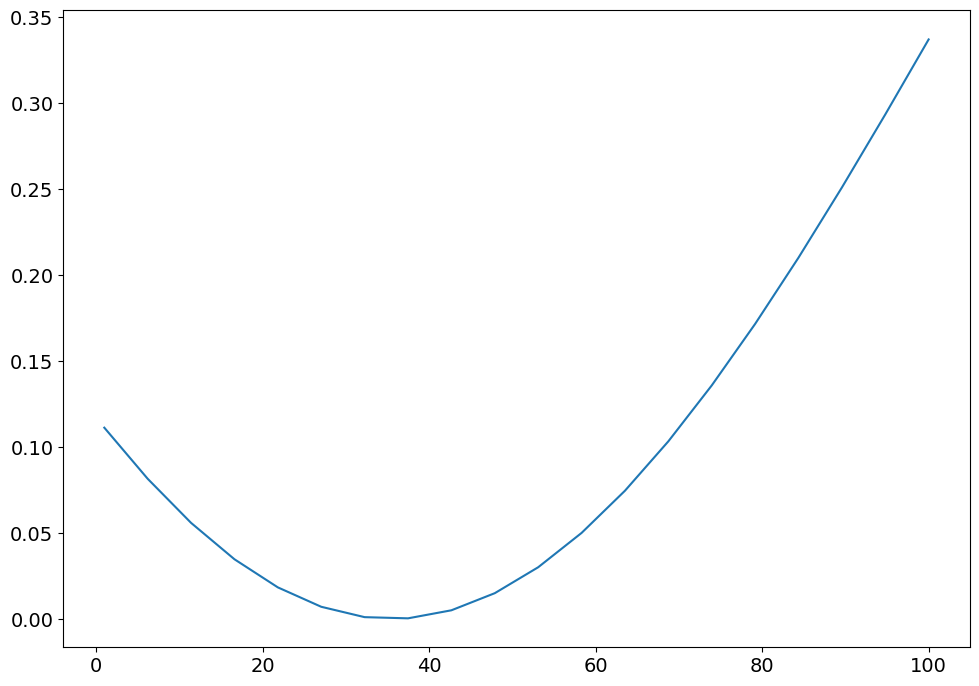

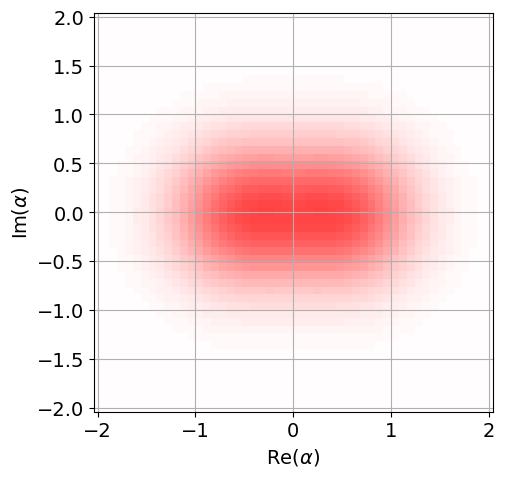

In [3]:
t_displace = np.linspace(0,0.132,3)
t_wait = np.linspace(0,0.08,3)
epsilon = 64

def overlapWithIdeal(epsilon):
    ideal  = CD_ideal_operator(1j)*vac
    exp = Rx(np.pi)*ECD_exp(vac, t_displace, t_wait, 1, epsilon = epsilon)
    overlap = exp.overlap(ideal)
    
    return 1-abs(overlap)

eps = np.linspace(1,100,20)

overlaps = []
for i in eps:
    overlaps.append(overlapWithIdeal(i))
plt.plot(eps,overlaps)
print(eps[np.argmin(overlaps)])
epsilon = eps[np.argmin(overlaps)]
psi1 = U(vac, t_displace, t_wait, 1, epsilon = epsilon)
plot_wigner(psi1)

# for U(1)

In [22]:
# dephasing

t2 = 20
q_dephasing = np.sqrt(1/t2) * sz
loss = [q_dephasing]

psi = U(vac, t_displace, t_wait, 1, epsilon = epsilon)
psi_loss = U(vac, t_displace, t_wait, 1, epsilon = epsilon, loss = loss)

print(expect(psi_loss,psi))


0.9667893632807673


In [23]:
# t1

t1 = 20
q_decay = np.sqrt(1/t1) * (sx + 1j * sy) / 2
loss = [q_decay]

psi = U(vac, t_displace, t_wait, 1, epsilon = epsilon)
psi_loss = U(vac, t_displace, t_wait, 1, epsilon = epsilon, loss = loss)

print(expect(psi_loss,psi))


(0.9894134621123225-1.0833523045857239e-17j)


In [ ]:
# cav t1
cav_t1 = 263


a_loss = np.sqrt(1/cav_t1) * a
loss = [a_loss]

psi = U(vac, t_displace, t_wait, 1, epsilon = epsilon)
psi_loss = U(vac, t_displace, t_wait, 1, epsilon = epsilon, loss = loss)

print(expect(psi_loss,psi))


In [4]:
# cav t2

cav_t2 = 5000
a_dephasing = np.sqrt(1/cav_t2) * (a * a.dag() + a.dag() * a)
loss = [a_dephasing]

psi = U(vac, t_displace, t_wait, 1, epsilon = epsilon)
psi_loss = U(vac, t_displace, t_wait, 1, epsilon = epsilon, loss = loss)

print(expect(psi_loss,psi))


0.993554989415933


In [18]:
# cav t2

cav_t2 = 4000
a_dephasing = np.sqrt(1/cav_t2) * (a * a.dag() + a.dag() * a)
loss = [a_dephasing]

psi = U(vac, t_displace, t_wait, 1, epsilon = epsilon)
psi_loss = U(vac, t_displace, t_wait, 1, epsilon = epsilon, loss = loss)

print(expect(psi_loss,psi))


0.9734372593751122


# For U(2)

In [6]:
# dephasing

t2 = 20
q_dephasing = np.sqrt(1/t2) * sz
loss = [q_dephasing]

psi = U(vac, t_displace, t_wait, 2, epsilon = epsilon)
psi_loss = U(vac, t_displace, t_wait, 2, epsilon = epsilon, loss = loss)

print(expect(psi_loss,psi))


0.9667828438651038


In [7]:
# t1

t1 = 18
q_decay = np.sqrt(1/t1) * (sx + 1j * sy) / 2
loss = [q_decay]

psi = U(vac, t_displace, t_wait, 2, epsilon = epsilon)
psi_loss = U(vac, t_displace, t_wait, 2, epsilon = epsilon, loss = loss)

print(expect(psi_loss,psi))


0.9856446455557852
